In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

In [ ]:
df=pd.read_csv('spam1.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

In [ ]:
df=df.dropna(axis=1)

In [ ]:
df.shape

(5572, 2)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Rename columns to meaningful names

In [ ]:
df.rename(columns={'v1':'category','v2':'msg'},inplace=True)

In [ ]:
df.head()

,category,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('category').describe()

msg                                                               
         count unique                                                top freq
category                                                                     
ham       4825   4516                             Sorry, I'll call later   30
spam       747    642  Please call our customer service representativ...    4

In [ ]:
df['category'].value_counts()

ham     4825
spam     747
Name: category, dtype: int64

Data set is imbalanced.Using Downsampling.

In [ ]:
count_ham,count_spam=df.category.value_counts()
df_spam=df[df['category']=='spam']
df_ham=df[df['category']=='ham']

In [ ]:
count_spam,count_ham

(747, 4825)

In [ ]:
df_spam.shape

(747, 2)

In [ ]:
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])

In [ ]:
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_spam.shape

(747, 2)

In [ ]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])

In [ ]:
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['category'].value_counts()

spam    747
ham     747
Name: category, dtype: int64

In [ ]:
df_balanced.sample(5)

,category,msg
5570,ham,The guy did some bitching but I acted like i'd...
5039,spam,Natalie (20/F) is inviting you to be her frien...
2602,ham,So when you gonna get rimac access
4699,spam,WIN: We have a winner! Mr. T. Foley won an iPo...
2208,spam,URGENT!! Your 4* Costa Del Sol Holiday or å£50...


Convert category to binary column

In [ ]:
df_balanced['spam']=df_balanced['category'].apply(lambda x :1 if x=='spam' else 0)

In [ ]:
df_balanced.head()

,category,msg,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


Split data into Train and  Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(df_balanced['msg'],df_balanced['spam'],test_size=0.2,random_state=5,stratify=df_balanced['spam'])

In [ ]:
X_train.head()

3109    Good Luck! Draw takes place 28th Feb 06. Good ...
4912    Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...
3541                       ÌÏ come lt 25 n pass to me lar
5330      Dude im no longer a pisces. Im an aquarius now.
3997    We tried to call you re your reply to our sms ...
Name: msg, dtype: object

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 23.9 MB/s eta 0:00:00


In [ ]:
import tensorflow_text

Importing BERT model

In [ ]:
bert_preprocess= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [58]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "Hi..How are you?",
    "Tomorrow is Holiday"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.93920565, -0.3873412 , -0.9245516 , ..., -0.7735728 ,
        -0.73180324,  0.92828876],
       [-0.8089941 , -0.25997868,  0.37760618, ...,  0.38579124,
        -0.62389535,  0.85770106]], dtype=float32)>

Compare embeding using cosine similarity

In [54]:
e = get_sentence_embeding([
    "apple",
    "banana",
    "cherry",
    "Priyanka chopra",
    "elon musk",
    "bill gates"
]
)

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9659779]], dtype=float32)

In [56]:
cosine_similarity([e[0]],[e[3]])

array([[0.93143165]], dtype=float32)

In [57]:
cosine_similarity([e[3]],[e[4]])

array([[0.96522]], dtype=float32)

Building Functional Model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
len(X_train)

1195

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Training Model

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 538s 14s/step - loss: 0.6432 - accuracy: 0.6460 - precision: 0.6465 - recall: 0.6432
Epoch 2/10
38/38 [==============================] - 516s 14s/step - loss: 0.4992 - accuracy: 0.8142 - precision: 0.8000 - recall: 0.8375
Epoch 3/10
38/38 [==============================] - 515s 14s/step - loss: 0.4325 - accuracy: 0.8594 - precision: 0.8545 - recall: 0.8660
Epoch 4/10
38/38 [==============================] - 515s 14s/step - loss: 0.3914 - accuracy: 0.8703 - precision: 0.8553 - recall: 0.8911
Epoch 5/10
38/38 [==============================] - 515s 14s/step - loss: 0.3638 - accuracy: 0.8854 - precision: 0.8686 - recall: 0.9079
Epoch 6/10
38/38 [==============================] - 519s 14s/step - loss: 0.3326 - accuracy: 0.8929 - precision: 0.8825 - recall: 0.9062
Epoch 7/10
38/38 [==============================] - 516s 14s/step - loss: 0.3207 - accuracy: 0.9021 - precision: 0.8909 - recall: 0.9162
Epoch 8/10
38/38 [=======================

In [47]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 140s 14s/step - loss: 0.2755 - accuracy: 0.8963 - precision: 0.8696 - recall: 0.9333


[0.2754766345024109,
 0.8963210582733154,
 0.8695651888847351,
 0.9333333373069763]

In [48]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 136s 13s/step


In [49]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1])

Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm


array([[128,  21],
       [ 10, 140]])

Text(50.722222222222214, 0.5, 'Truth')

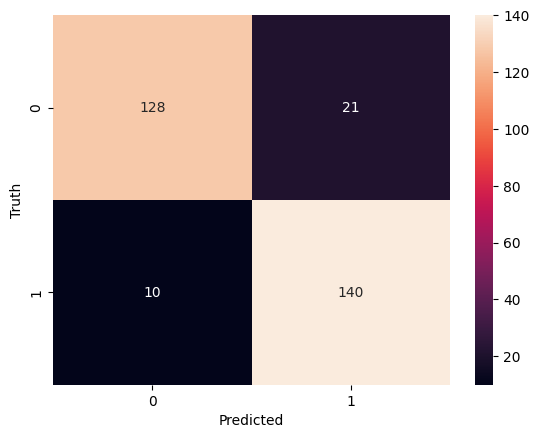

In [51]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [52]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       149
           1       0.87      0.93      0.90       150

    accuracy                           0.90       299
   macro avg       0.90      0.90      0.90       299
weighted avg       0.90      0.90      0.90       299



Prediction

In [53]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 6s 6s/step


array([[0.7949598 ],
       [0.8512438 ],
       [0.79888755],
       [0.21501681],
       [0.1150488 ]], dtype=float32)